## loading the data and packages

In [397]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from datetime import datetime as dt


import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.sparse import csr_matrix


In [277]:
data = pd.read_csv('bank_transactions.csv', delimiter = ',') # original csv

In [3]:
# loading dataframes and concatenating
data_20 = pd.read_csv('twenty_params_2.csv', delimiter = ',')#.drop(['Unnamed: 0'], axis = 1)
data_7 = pd.read_csv('seven_params_2.csv', delimiter = ',').reset_index(drop=True)
data_27 = pd.concat([data_20, data_7], axis = 1)
data_27.set_index('CustomerID', inplace = True)

In [4]:
# fill NA cells with 0 & replace inf values with 0
data_27.fillna(0, inplace = True)
data_27.replace([np.inf, -np.inf], 0, inplace=True)

In [5]:
# for now selecting only numerical values
cols_for_norm = data_27.columns[0:28]
data_num = data_27[cols_for_norm]
data_num.head()

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio,nr_trans,TransactionAmount_INR,mean_trans,mean_balance,mean_diff,gender_most_freq
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,87679.81,...,2,28.0,0.074556,0.002962,2,2.0,2553.0,76340.635,73787.635,0
C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,0.00,...,1,22.0,0.061931,0.061931,1,1.0,1499.0,24204.490,22705.490,1
C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,123471.62,...,2,27.0,0.016472,0.001545,2,2.0,727.5,100112.950,99385.450,0
C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,0.00,...,1,26.0,0.060462,0.060462,1,0.0,30.0,496.180,466.180,0
C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,0.00,...,1,51.0,0.057433,0.057433,1,1.0,5000.0,87058.650,82058.650,1


## 2.2 Choose your features (variables)!

### Data Normalization
The initial data contains both continuous and discrete features which implies that the features variances may be of very different scales. We conduct a dimensionality reduction by PCA and want to obtain dimensions that retain information from both feature types.
If this step is not conducted a PCA to a single dimension will already retain 80% of variance. To illustrate we plot below the PCA of unnormalized data projected into the space of the first two principal components (3 in total). Clustering with k = 5 is conducted and the centroids shown as 'x'

Text(0.5, 1.0, 'k = 5 for unnormalized data')

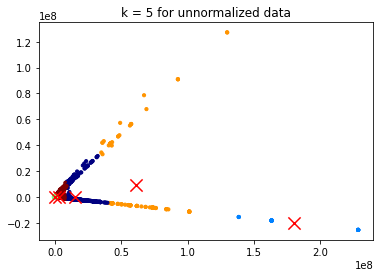

In [284]:
pca = PCA(n_components=3) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data_notnorm = pca.fit_transform(data_num)

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data_notnorm)

plt.scatter(pca_data_notnorm[:, 0], pca_data_notnorm[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('k = 5 for unnormalized data')

Using sklearn.preprocessing functions, we preprocess the data.

In [253]:

stdScaler = StandardScaler()
fctScaler = FunctionTransformer(np.log1p)
#fctScaler2 = FunctionTransformer(np.log10)

minmaxScaler = MinMaxScaler()
maxScaler = MaxAbsScaler()
powerScaler = PowerTransformer() #  diffbalsnce!
robScaler = RobustScaler()
normScaler = Normalizer()


cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'TransactionAmount_INR', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ 'mean_trans', 'mean_balance',  '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio','mean_diff',]


In [254]:
data_norm = data_num.copy() # 

data_norm[cols_for_std_scaling] = stdScaler.fit_transform(data_norm[cols_for_std_scaling])
data_norm[cols_for_fct_scaling] = fctScaler.transform(data_norm[cols_for_fct_scaling])
data_norm[cols_for_pow_scaling] = powerScaler.fit_transform(data_norm[cols_for_pow_scaling])
#data_norm[cols_for_rob_scaling] = robScaler.fit_transform(data_norm[cols_for_rob_scaling])
#data_norm[cols_for_norm_scaling] = normScaler.fit_transform(data_norm[cols_for_norm_scaling])

#data_norm = normScaler.fit_transform(data_norm)
#data_norm[cols_for_max_scaling] = maxScaler.fit_transform(data_norm[cols_for_max_scaling])


In [ ]:
data_num.head()

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio,nr_trans,TransactionAmount_INR,mean_trans,mean_balance,mean_diff,gender_most_freq
count,839081.000000,839081.000000,839081.000000,839081.000000,8.390810e+05,8.390810e+05,8.390810e+05,839081.000000,839081.000000,839081.000000,...,839081.000000,839081.000000,839081.000000,839081.000000,839081.000000,839081.000000,839081.000000,839081.000000,839081.000000,839081.000000
mean,5.861178,6.150128,0.943233,1.102587,-7.005912e-16,3.507226e-16,1.838181e-14,9.175517,0.001053,-0.317182,...,1.172834,3.424911,-0.054165,0.330914,1.174287,0.619386,6.077659,9.524227,-0.427568,0.724595
std,1.588608,1.577101,0.554212,0.483528,1.000001e+00,1.000001e+00,1.000001e+00,2.527143,0.007654,0.398034,...,0.432921,0.237116,0.037818,0.349043,0.435129,0.312488,1.539402,2.380394,0.567848,0.446718
min,0.000000,0.000000,0.000000,0.000000,-2.458616e-01,-2.302779e-01,-4.187044e+01,0.000000,0.000000,-0.991579,...,1.000000,2.772589,-0.990712,0.000000,1.000000,0.000000,0.000000,0.000000,-0.999665,0.000000
25%,4.836282,5.278115,1.000000,1.000000,-2.157860e-01,-2.026966e-01,3.448957e-02,8.209115,0.000049,-0.514518,...,1.000000,3.258097,-0.070716,0.043287,1.000000,0.693147,5.198497,8.588060,-0.848279,0.000000
50%,5.886104,6.216606,1.000000,1.000000,-1.660334e-01,-1.584093e-01,3.448957e-02,9.500014,0.000167,-0.426122,...,1.000000,3.401197,-0.058701,0.171542,1.000000,0.693147,6.165418,9.780370,-0.696797,1.000000
75%,6.908755,7.182352,1.000000,1.000000,-4.589132e-02,-5.028966e-02,3.448957e-02,10.710081,0.000555,-0.149557,...,1.000000,3.555348,-0.031787,0.579769,1.000000,0.693147,7.070495,10.954965,-0.115946,1.000000
max,14.260219,14.260219,6.000000,6.000000,2.493226e+02,2.634204e+02,3.448957e-02,18.560751,1.000000,0.999974,...,6.000000,4.753590,0.999999,1.000000,6.000000,1.945910,14.260219,18.560751,1.000000,1.000000


In [ ]:
'''
cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']


cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans','mean_ratio' ,'mean_trans', 'mean_balance','TransactionAmount_INR',  'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans']
cols_fro_minmax_scaling = ['min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']

cols_for_std_scaling = [ 'TransactionAmount_INR',  'diff_balance', ]
cols_for_fct_scaling = [ 'min_trans', 'max_trans', '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_rob_scaling = ['TransactionAmount_INR',  'diff_balance',]
cols_for_norm_scaling = ['mean_trans', 'mean_balance', 'mean_diff','mean_ratio','mean_age_trans']
cols_for_pow_scaling = [  'max_ratio']


cols_for_std_scaling = ['0.75_quant_trans', '0.25_quant_trans',  'diff_balance', 'mean_diff',  'trans_val_var', 'mean_ratio']
cols_for_fct_scaling = [ 'mean_trans', 'mean_balance', 'TransactionAmount_INR','min_trans', 'max_trans', 'min_balance','mean_age_trans' ]
#cols_for_rob_scaling = ['TransactionAmount_INR',  'diff_balance',]
cols_for_norm_scaling = ['mean_ratio', 'diff_balance', 'mean_diff', 'max_ratio'] 
cols_for_max_scaling = [ 'max_balance','max_ratio', ]


# TODO: former combinations !select better option
stdScaler = StandardScaler()
fctScaler = FunctionTransformer(np.log1p)
minmaxScaler = MinMaxScaler()
powerScaler = PowerTransformer() #  diffbalsnce!

cols_for_std_scaling = [ 'TransactionAmount_INR', 'mean_balance', 'mean_diff', 'diff_balance']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans', 'mean_ratio']
cols_for_pow_scaling = []
cols_for_minmax_scaling = ['min_trans', 'max_trans', 'max_ratio','min_balance', 'max_balance','mean_trans'] #'mean_age_trans'



cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']



cols_for_std_scaling = [ 'diff_balance', 'mean_ratio', 'max_ratio', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff']
cols_for_fct_scaling = ['min_trans', 'max_trans', '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']


'''

We conduct the same illustration as above for normalized data: Do a principal component analysis with n_components = 3 and cluster the data with k = 5 centroids.

Text(0.5, 1.0, 'k = 5 for normalized data')

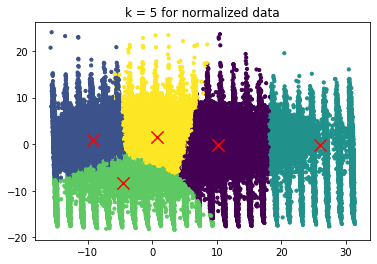

In [257]:
pca = PCA(n_components=3) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data = pca.fit_transform(data_norm)

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('k = 5 for normalized data')

### Dimensionality Reduction
The dimensionality is reduced using sklearns PCA method. The number of dimensions is chosen such that the 80 % of the total data variance is retained.

In [395]:
# use sklearn pca to transform the data
pca = PCA(n_components=0.80) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data = pca.fit_transform(data_norm) # back to data_num from data_norm because kmeans says 0 vectors, no! my fault
print(pca_data.shape)

sparse_pca_data = csr_matrix(pca_data)

(839081, 3)


In [259]:
pca_data.var()
pca.explained_variance_

array([97.48710111, 18.22697518,  7.59873236])

In [ ]:
# TODO:  Explain why you chose that method and the limitations it may have.

## 2.3 Clustering!

I tried to use a map reduce format, not elegant and slow but seemingly working at this point. Using the whole dataset (reduced to 4 dimensions) an iteration takes 10 s
TODO: easiest part to improve is when generating shuffled assignment ? 

In [ ]:
# old function!
#
def makeNewCentroids_original(assigned): #shuffle in sense that all centroids are group together and reduce by calculating new centroids from data
    shuffled = {}
    #fill_dict =  lambda k, v : shuffled.setdefault(k, []).append(v)
    #map(lambda x: fill_dict(x[0],x[1]), assigned)
    for e in assigned:
        try:
            shuffled[e[0]].append(e[1])
        except:
            shuffled[e[0]] = [e[1]]

    new_centroids = calcNewCentroid(shuffled)
    #centroids_hist[iter+1] = new_centroids
    return (shuffled, new_centroids)
    # ?? fused these two part into makeNewCentroids below ??
def calcNewCentroid(shuffled):
    centroids = map( lambda rows: np.mean(data[rows], axis = 0), shuffled.values())
    arr =  np.array(list(centroids))
    #arr = np.fromiter(centroids, dtype=np.float32)
    return arr

In [297]:
## matteos first implementation, with mapping and reducing 

def findNearCentroid(row): # map
    dist = np.sum((centroids_hist[iter]-data[row])**2, axis=1)
    closest = np.argmin(dist)
    return(closest,row) # opposite wont work


def makeNewCentroids(assigned): #shuffle in sense that all centroids are grouped together and reduce by calculating new centroids from data
    shuffled = {}
    #fill_dict =  lambda k, v : shuffled.setdefault(k, []).append(v)
    #map(lambda x: fill_dict(x[0],x[1]), assigned)
    for e in assigned:
        try:
            shuffled[e[0]].append(e[1])
        except:
            shuffled[e[0]] = [e[1]]

    centroids = map( lambda rows: np.mean(data[rows], axis = 0), shuffled.values())
    new_centroids = np.array(list(centroids))
    return (shuffled, new_centroids)

    

def kmeans(k, data, maxIter):
    centroids = np.random.randint(0, data.shape[0], k)
    
    global centroids_hist
    centroids_hist = np.zeros((maxIter+1, k, data.shape[1]), dtype=float)
    centroids_hist[0]= data[centroids]

    rows = np.arange(0, data.shape[0])

    global iter 
    iter = 0

    converge = False

    while tqdm(iter < maxIter and not converge):
        centroids = centroids_hist[iter]
        assigned = map(findNearCentroid, rows) # mapping
        # cp_assigned = [el for el in assigned] # cant copy or modify map object 'assigned' or is empty when passed to makeNewCentoids
        # so access in 

        shuffled, new_centroids = makeNewCentroids(assigned) # shuffling and reducing
        centroids_hist[iter+1] = new_centroids ## fails at times

        if iter > 0 and np.array_equal(centroids_hist[iter],centroids_hist[iter+1]):
             converge = True
             
        iter +=1

    return centroids_hist, shuffled


In [241]:
# TODO: sometimes fails, because broadcasting shape in part ***, how come nr centroids smalle that init?
# test_data is 100 row smaple
data  = pca_data

out = kmeans(5, data, 3) # 10s for an iteration of whole dataset

0
1
2


### Optimal Number of Clusters 
We run the clustering algorithm with n_clusters set in the range [1,10]

#### Elbow Method
Plotting the sum of square distances of data to closest centroid versus the number of centroids.

In [261]:
var = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
    kmeans.fit(sparse_pca_data)
    var.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow method for ideal # clusters')

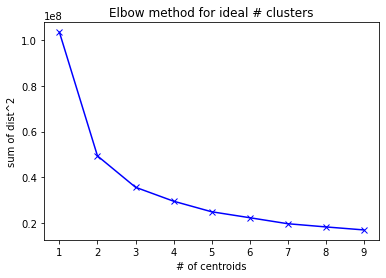

In [262]:
plt.plot(np.arange(1,10), var, 'bx-')
plt.xlabel('# of centroids')
plt.ylabel('sum of dist^2')
plt.title('Elbow method for ideal # clusters')

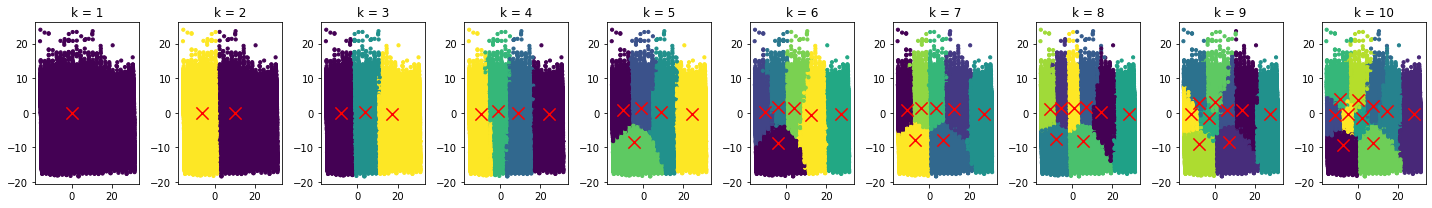

In [260]:

fig,ax = plt.subplots(1,10, figsize = (20,3))

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
    kmeans.fit(sparse_pca_data)

    cmap = plt.cm.get_cmap('jet', i)

    ax[i-1].scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

    centroids = kmeans.cluster_centers_
    ax[i-1].scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
    ax[i-1].set_title('k = '+str(i))

fig.tight_layout()

In [ ]:
# TODO !! this is a markdown 
# The elbow method indicates that the ideal number of clusters is around 3, 4 or 5 may also be considered. Given the above plot we can not clearly state the ideal number of clusters. The first vertical splitting of clusters is observed when going from 4 to 5. Choose k = 5.

### Run the Algorithm
We run our algorithm with k=5 and 20 iterations. The data has shape (839081, 3) and one iteration takes around 10 seconds.

In [298]:
data  = pca_data
out = kmeans(5, data, 20)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [299]:
# for each data row (customerID) get cluster centroid, used to plot colors

d = out[1] # dictionary of clusterID : [data rows]
cols = []
for k,v in d.items():
    for x in v:
        cols.append([x,k])

cols = np.array(cols)
cols = cols[cols[:, 0].argsort()][:,1]

# centroids of the last iteration
centroids = out[0][3] 


Text(0.5, 1.0, 'K-means with k = 5')

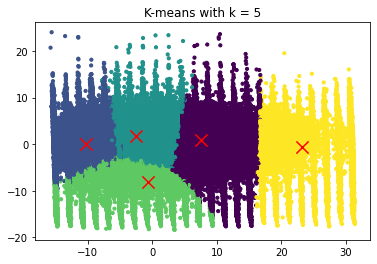

In [300]:
plt.scatter(data[:, 0], data[:, 1], s=10, c = cols)

plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means with k = 5')
# TODO: ! run with higher iteration ? 

### KMeans with scikit-learn Library

Text(0.5, 1.0, 'K-means++ with k = 5')

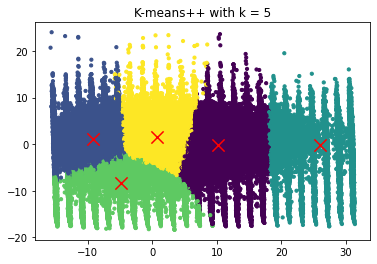

In [301]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means++ with k = 5')

K-means++ clusters similar to our K-means algorithm. There's a visibly a slight shifting of cluster centers but we can not assert this to the difference in the algorithms, since we only run 20 iterations.

## 2.4 Analysing your results!

In [381]:
import math
# function takes a column of the numerical dataframe data_num
# cols is the array of cluster_indexes for each row, as returned by our kmeans algorithm

def make_bins_pv (columns, cols) -> pd.DataFrame:
    mn = min(columns)
    mx = math.ceil(max(columns))
    bins = np.arange(mn, mx, math.ceil((mx-mn)/4) )
    bins = np.append(bins, mx)
    cut = pd.cut(x=columns, bins=bins)
    dumm = pd.get_dummies(cut)
    pv = pd.pivot_table(dumm, index = cols)
    pv.index.name = 'Cluster'
    return pv

In [385]:
col = data_num['mean_trans']
mean_trans = make_bins_pv(col, cols)
mean_trans.style.set_caption('Mean Transaction')

,"(0.0, 390009.0]","(390009.0, 780018.0]","(780018.0, 1170027.0]","(1170027.0, 1560035.0]"
Cluster,,,,
0,0.999165,0.000019,0.000000,0.000000
1,0.999858,0.000012,0.000000,0.000000
2,0.999715,0.000042,0.000004,0.000008
3,0.999344,0.000000,0.000000,0.000000
4,0.995824,0.000000,0.000000,0.000000


In [386]:

col = data_num['trans_greater_1k']
trans_greater_1k = make_bins_pv(col, cols)
trans_greater_1k.style.set_caption('Number of Transactions greater than 1K')

,"(0.0, 2.0]","(2.0, 4.0]","(4.0, 6.0]"
Cluster,,,
0,0.782394,0.007870,0.000028
1,0.857650,0.005742,0.000028
2,0.867740,0.019826,0.000123
3,0.712445,0.002828,0.000000
4,0.661305,0.001739,0.000000


In [388]:

col = data_num['most_freq_hour']
most_freq_hour = make_bins_pv(col, cols)
most_freq_hour.style.set_caption('Most Frequent Hour of Transaction')


,"(0, 6]","(6, 12]","(12, 18]","(18, 23]"
Cluster,,,,
0,0.015529,0.747302,0.229244,0.005045
1,0.000000,0.000000,0.018375,0.981625
2,0.000000,0.032219,0.903608,0.064173
3,0.000000,0.025878,0.557193,0.416929
4,0.528656,0.197354,0.000000,0.000000


In [389]:

col = data_num['mean_balance']
most_freq_hour = make_bins_pv(col, cols)
most_freq_hour.style.set_caption('Mean Balance')

,"(0.0, 28758874.0]","(28758874.0, 57517748.0]","(57517748.0, 86276622.0]","(86276622.0, 115035496.0]"
Cluster,,,,
0,0.999329,0.000113,0.000033,0.000005
1,0.999931,0.000053,0.000000,0.000016
2,0.999827,0.000112,0.000050,0.000012
3,0.981456,0.000000,0.000000,0.000000
4,0.997862,0.000020,0.000000,0.000000


In [391]:

col = data_num['gender_most_freq']
dumm = pd.get_dummies(col)
pv = pd.pivot_table(dumm, index = cols)
pv.index.name = 'Cluster'
pv.style.set_caption('Most Frequent Gender')

,0,1
Cluster,,
0,0.258916,0.741084
1,0.276232,0.723768
2,0.313982,0.686018
3,0.225230,0.774770
4,0.209824,0.790176


In [392]:

col = data_num['mean_age_trans']
mean_age_trans = make_bins_pv(col, cols)
mean_age_trans.style.set_caption('Mean Age at Transaction')

,"(15.0, 40.0]","(40.0, 65.0]","(65.0, 90.0]","(90.0, 115.0]"
Cluster,,,,
0,0.881469,0.109976,0.007860,0.000615
1,0.899228,0.096247,0.003834,0.000627
2,0.876253,0.116583,0.006602,0.000492
3,0.939162,0.056391,0.003688,0.000627
4,0.913653,0.080872,0.004756,0.000480


In [403]:
calinski_harabasz_score = metrics.calinski_harabasz_score(pca_data, cols)
calinski_harabasz_score

654358.7974452751

Calinski Harabasz Score = 654358.8 
The ratio between intracluster disperion and intercluster dispersion.

In [402]:
davies_bouldin_score = metrics.davies_bouldin_score(pca_data, cols)
davies_bouldin_score


0.9697838284393517

Davies Bouldin Score = 0.97
The ratio of intracluster distance to intercluster distance is a value within the range (0,1).
The high score is in accordance to what we observe when plotting the two PC or look at the pivot tables. The customers don't cluster into distinct groups and the large number of parameters results in one blob of data, hence the distance between any data is lower.

In [ ]:
# TODO: want to run? at min 30 minutes and no output so far
from sklearn.metrics import silhouette_score
#silhouette = silhouette_score(pca_data, cols)
